#Modelo1 - Predicción de inversión monetaria (Q.)

Este modelo busca predecir la inversión en Quetzales que la empresa tendra que hacer en la compra de mercaderia para su inventario.
Los datos de entradas seran las fechas y demas caracteristicas relacionadas y la salida sera la predicción de la cantidad en Quetzales que la empresa invertira.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
df = pd.read_csv('inversion_mercaderia.csv', parse_dates=['fecha'])
df = df.sort_values('fecha').reset_index(drop=True)

In [ ]:
# Análisis exploratorio
print(f"Rango de fechas: {df['fecha'].min()} a {df['fecha'].max()}")
print(f"Total de registros: {len(df)}")
print(f"Porcentaje de días con compra cero: {100*(df['total_compras'] == 0).mean():.1f}%")

Rango de fechas: 2024-04-01 00:00:00 a 2025-05-31 00:00:00
Total de registros: 396
Porcentaje de días con compra cero: 8.8%


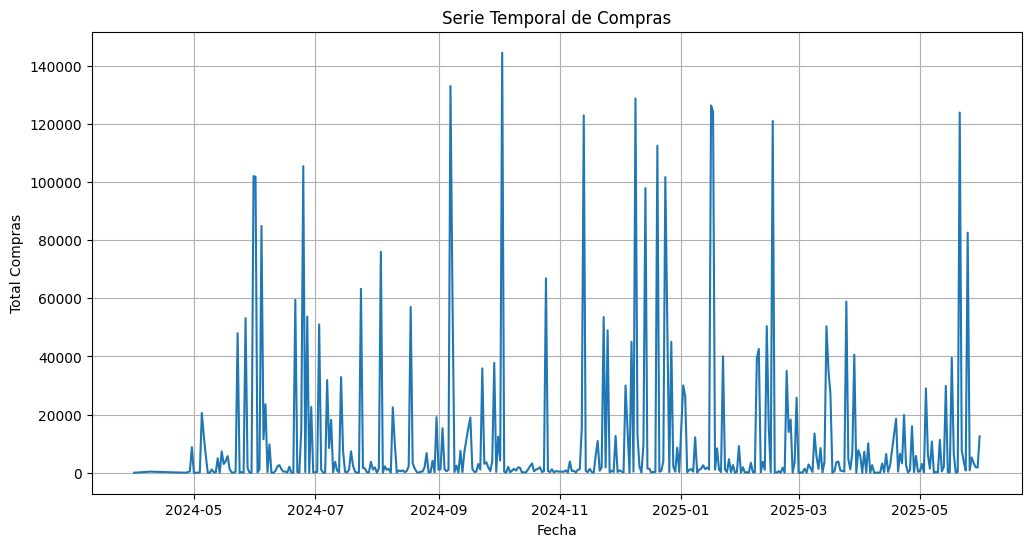

In [ ]:
# Visualización de la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(df['fecha'], df['total_compras'])
plt.title('Serie Temporal de Compras')
plt.xlabel('Fecha')
plt.ylabel('Total Compras')
plt.grid()
plt.show()

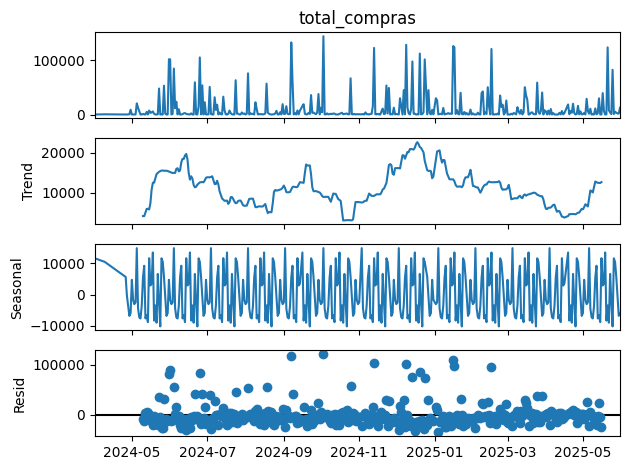

In [ ]:
# Descomposición de la serie temporal (para identificar tendencia y estacionalidad)
decomposition = seasonal_decompose(df.set_index('fecha')['total_compras'], period=30)
decomposition.plot()
plt.show()

In [ ]:
# Feature engineering
def create_features(df):
    df = df.copy()
    df['dia'] = df['fecha'].dt.day
    df['mes'] = df['fecha'].dt.month
    df['ano'] = df['fecha'].dt.year
    df['dia_semana'] = df['fecha'].dt.dayofweek
    df['dia_ano'] = df['fecha'].dt.dayofyear
    df['trimestre'] = df['fecha'].dt.quarter
    df['es_fin_de_semana'] = df['dia_semana'].isin([5, 6]).astype(int)

    # Lag features
    df['lag_1'] = df['total_compras'].shift(1)
    df['lag_7'] = df['total_compras'].shift(7)
    df['lag_30'] = df['total_compras'].shift(30)

    # Rolling statistics
    df['rolling_mean_7'] = df['total_compras'].rolling(window=7).mean()
    df['rolling_std_7'] = df['total_compras'].rolling(window=7).std()
    df['rolling_max_7'] = df['total_compras'].rolling(window=7).max()

    return df

df = create_features(df)
df.head(40)


,id,fecha,total_compras,dia,mes,ano,dia_semana,dia_ano,trimestre,es_fin_de_semana,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,rolling_max_7
30,1201,2024-05-25,228.00,25,5,2024,5,146,2,1,NaN,NaN,NaN,NaN,NaN,NaN
31,1235,2024-05-26,0.00,26,5,2024,6,147,2,1,228.00,NaN,NaN,NaN,NaN,NaN
32,1258,2024-05-27,53180.00,27,5,2024,0,148,2,0,0.00,NaN,NaN,NaN,NaN,NaN
33,1267,2024-05-28,1600.00,28,5,2024,1,149,2,0,53180.00,NaN,NaN,NaN,NaN,NaN
34,1306,2024-05-29,0.00,29,5,2024,2,150,2,0,1600.00,NaN,NaN,NaN,NaN,NaN
35,1321,2024-05-30,0.00,30,5,2024,3,151,2,0,0.00,NaN,NaN,NaN,NaN,NaN
36,1341,2024-05-31,102000.00,31,5,2024,4,152,2,0,0.00,NaN,NaN,22429.714286,40234.893238,102000.00
37,1391,2024-06-01,101830.00,1,6,2024,5,153,2,1,102000.00,228.00,NaN,36944.285714,48390.528638,102000.00
38,1417,2024-06-02,112.00,2,6,2024,6,154,2,1,101830.00,0.00,NaN,36960.285714,48376.293787,102000.00
39,1426,2024-06-03,1185.00,3,6,2024,0,155,2,0,112.00,53180.00,NaN,29532.428571,49450.607188,102000.00


In [ ]:
# Eliminar filas con NaN (por los lags)
df = df.dropna()
df.head()

,id,fecha,total_compras,dia,mes,ano,dia_semana,dia_ano,trimestre,es_fin_de_semana,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,rolling_max_7
60,1991,2024-06-24,14620.0,24,6,2024,0,176,2,0,0.0,0.0,228.0,10913.928571,22055.480416,59450.0
61,2044,2024-06-25,105400.0,25,6,2024,1,177,2,0,14620.0,2087.5,0.0,25672.857143,41319.074173,105400.0
62,2084,2024-06-26,243.0,26,6,2024,2,178,2,0,105400.0,0.0,53180.0,25707.571429,41294.004706,105400.0
63,2110,2024-06-27,53720.0,27,6,2024,3,179,2,0,243.0,0.0,1600.0,33381.857143,40707.745465,105400.0
64,2131,2024-06-28,60.0,28,6,2024,4,180,2,0,53720.0,59450.0,0.0,24897.571429,40557.859098,105400.0


In [ ]:
# Separar features y target
X = df.drop(columns=['id','fecha', 'total_compras'])
y = df['total_compras']

In [ ]:
# Train/test split (cronológico)
split_date = '2025-03-01'
train = df[df['fecha'] < split_date]
test = df[df['fecha'] >= split_date]

X_train, y_train = train.drop(columns=['id','fecha', 'total_compras']), train['total_compras']
X_test, y_test = test.drop(columns=['id','fecha', 'total_compras']), test['total_compras']


In [ ]:
# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


XGBoost Metrics:
MAE: 9176.83
RMSE: 17185.51
R²: 0.14
Index(['dia', 'mes', 'ano', 'dia_semana', 'dia_ano', 'trimestre',
       'es_fin_de_semana', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7',
       'rolling_std_7', 'rolling_max_7'],
      dtype='object')


<Figure size 1000x600 with 0 Axes>

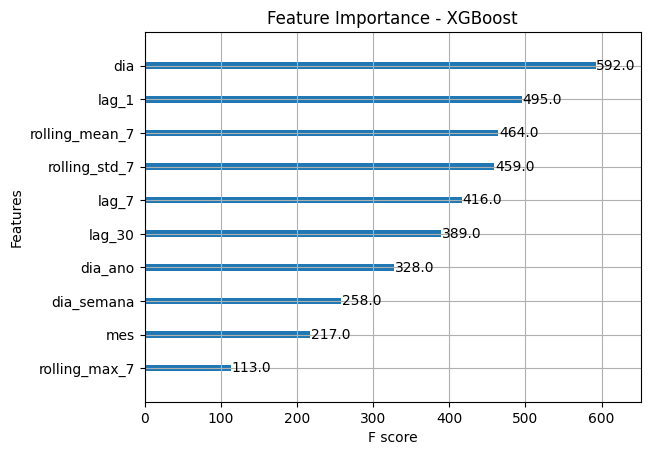

In [ ]:
# Modelo XGBoost
model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_xgb.fit(X_train, y_train)

# Predicciones
y_pred_xgb = model_xgb.predict(X_test)

# Métricas
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Metrics:")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.2f}")
print(X_test.columns)

# Feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model_xgb, max_num_features=10)
plt.title('Feature Importance - XGBoost')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

MLP Metrics:
MAE: 8520.07
RMSE: 20171.76
R²: -0.19


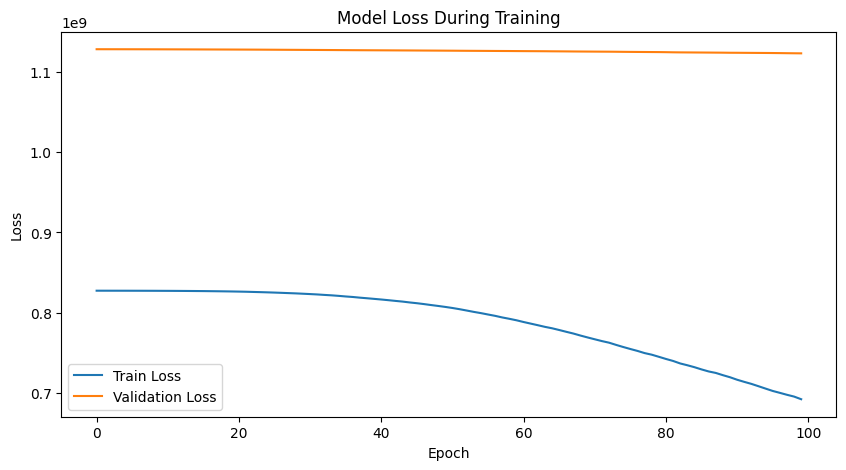

In [ ]:
# Modelo MLP
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
model_mlp.add(Dense(32, activation='relu'))
model_mlp.add(Dense(1))

model_mlp.compile(optimizer='adam', loss='mse')

history = model_mlp.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Predicciones
y_pred_mlp = model_mlp.predict(X_test_scaled).flatten()

# Métricas
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)

print("\nMLP Metrics:")
print(f"MAE: {mae_mlp:.2f}")
print(f"RMSE: {rmse_mlp:.2f}")
print(f"R²: {r2_mlp:.2f}")

# Gráfico de pérdida durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Preparar datos para LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 14  # Usar 14 días de historia
X_train_seq, y_train_seq = create_sequences(y_train.values, n_steps)
X_test_seq, y_test_seq = create_sequences(y_test.values, n_steps)

# Modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Predicciones
y_pred_lstm = model_lstm.predict(X_test_seq).flatten()

# Métricas
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print("\nLSTM Metrics:")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R²: {r2_lstm:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step

LSTM Metrics:
MAE: 10025.46
RMSE: 20871.14
R²: -0.10


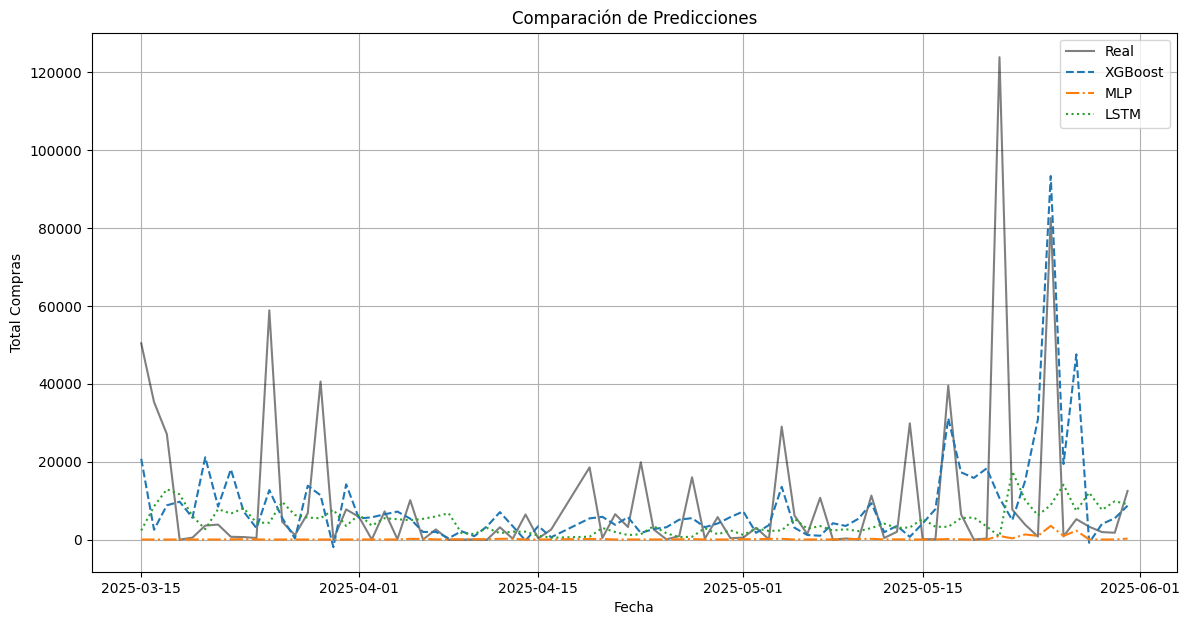

In [ ]:
# Crear dataframe con resultados
results = pd.DataFrame({
    'Fecha': test['fecha'].iloc[n_steps:].reset_index(drop=True),
    'Real': y_test_seq,
    'XGBoost': y_pred_xgb[n_steps:],
    'MLP': y_pred_mlp[n_steps:],
    'LSTM': y_pred_lstm
})

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(results['Fecha'], results['Real'], label='Real', color='black', alpha=0.5)
plt.plot(results['Fecha'], results['XGBoost'], label='XGBoost', linestyle='--')
plt.plot(results['Fecha'], results['MLP'], label='MLP', linestyle='-.')
plt.plot(results['Fecha'], results['LSTM'], label='LSTM', linestyle=':')
plt.title('Comparación de Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Total Compras')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Prediccion de un nuevo dato
nuevo_dia = {
    'dia': 15,
    'mes': 6,
    'ano': 2025,
    'dia_semana': 6,  # Suponiendo que es domingo
    'dia_ano': 166,
    'trimestre': 3,
    'es_fin_de_semana': 1,
    'lag_1': 1200.0,
    'lag_7': 9500.0,
    'lag_30': 30000.0,
    'rolling_mean_7': 4500.0,
    'rolling_std_7': 1000.0,
    'rolling_max_7': 15000.0
}

# XGBoost
input_xgb = pd.DataFrame([nuevo_dia])
pred_xgb = model_xgb.predict(input_xgb)[0]

# MLP
input_mlp = pd.DataFrame([nuevo_dia])
input_mlp_scaled = scaler.transform(input_mlp)
pred_mlp = model_mlp.predict(input_mlp_scaled)[0][0]

# Resultados
print(f"Predicción para 15/06/2025:\nXGBoost: Q{pred_xgb:.2f}\nMLP: Q{pred_mlp:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Predicción para 15/06/2025:
XGBoost: Q2118.67
MLP: Q186.83
